# Imports

In [1259]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Importar dataset

In [1260]:
!kaggle datasets download itsnahm/baldness-probability -p . --unzip

Dataset URL: https://www.kaggle.com/datasets/itsnahm/baldness-probability
License(s): unknown




  0%|          | 0.00/373k [00:00<?, ?B/s]
100%|██████████| 373k/373k [00:00<00:00, 927kB/s]
100%|██████████| 373k/373k [00:00<00:00, 927kB/s]


In [1261]:
df = pd.read_csv("./bald_probability.csv")
df.head(5)

,age,gender,job_role,province,salary,is_married,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob
0,27.0,female,Government Employee,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,Bachelor Degree,5.0,0.605974
1,53.0,female,Government Employee,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,Bachelor Degree,7.0,0.532860
2,37.0,female,Employee,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,Bachelor Degree,4.0,0.418442
3,36.0,female,Jobless,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,Elementary School,9.0,0.804050
4,38.0,male,NaN,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,Magister Degree,1.0,0.368371


# Analisis del dataset

## Descripcion del dataset
Este dataset muestra la probabilidad que tienen las personas de quedarse calvas en Indonesia en base a varias caracteristicas como pueden ser, si es fumador, su edad, su genereo..., vamos a hacer un analisis de cada columna y asi comprender que nos muestra cada una de ellas y como puede afectar a la probabilidad de la calvicie.  

A medida que hagamos ese analisis de columnas podremos ir aplicando algun que otro tipo de escalado, solo si es necesario para poder representar la caracteristica.

Despues si buscaremos el reescalado de datos para facilitar el uso y la comprension de los datos de nuetro modelo de ML de regresion lineal.

## Nulos

In [1262]:
print(f"Filas totales: {df.shape}\nNulos:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Filas totales: (7917, 14)
Nulos:
age                85
gender             77
job_role         1317
province           86
salary             74
is_married         72
is_hereditary      89
weight             56
height             74
shampoo            59
is_smoker          70
education          70
stress             64
bald_prob          79
dtype: int64


In [1263]:
df["job_role"].unique()

array(['Government Employee', 'Employee', 'Jobless', nan], dtype=object)

Vamos a ver el porcentaje de cada uno y aplicarse a los nan con la misma proporcion

In [1264]:
def mostrar_jobs():
    gov = df["job_role"][df["job_role"] == "Government Employee"].count()
    employee = df["job_role"][df["job_role"] == "Employee"].count()
    jobless = df["job_role"][df["job_role"] == "Jobless"].count()
    total = gov + employee + jobless

    print(f"Government Employee: {gov}/{total} ({gov/total:0.2f}%)\nEmployee: {employee}/{total} ({employee/total:0.2f}%)\nJobless: {jobless}/{total} ({jobless/total:0.2f}%)")
    return [gov, employee, jobless]
mostrar_jobs()

Government Employee: 3108/6600 (0.47%)
Employee: 3160/6600 (0.48%)
Jobless: 332/6600 (0.05%)


[3108, 3160, 332]

In [1265]:
proporciones = {
    'Government Employee': 0.47,
    'Employee': 0.48,
    'Jobless': 0.05
}

n_nan = df['job_role'].isna().sum()

categorias = list(proporciones.keys())
probabilidades = list(proporciones.values())

nan_indices = df['job_role'].isna()
df.loc[nan_indices, 'job_role'] = np.random.choice(categorias, size=n_nan, p=probabilidades)

In [1266]:
print(df["job_role"].isnull().sum())
print(df["job_role"].unique())
print(df["job_role"].count())

0
['Government Employee' 'Employee' 'Jobless']
7917


In [1267]:
mostrar_jobs()

Government Employee: 3729/7917 (0.47%)
Employee: 3800/7917 (0.48%)
Jobless: 388/7917 (0.05%)


[3729, 3800, 388]

Asi hemos conseguido rellenar los nulos de la columna proporcionalmente a los valores existentes sin tener que eliminar una gran parte de los registros

In [1268]:
df.dropna(inplace=True)
df.shape

(7018, 14)

El resto de los nulos si han sido eliminados y hemos perdido alrededor de 900 registros

## Columnas

### Age

La columna "age" nos indica la edad de la persona

#### Describe

In [1269]:
df["age"].describe()

count    7018.000000
mean       39.514819
std         9.885182
min         2.000000
25%        33.000000
50%        39.000000
75%        46.000000
max        77.000000
Name: age, dtype: float64

#### Analisis grafico

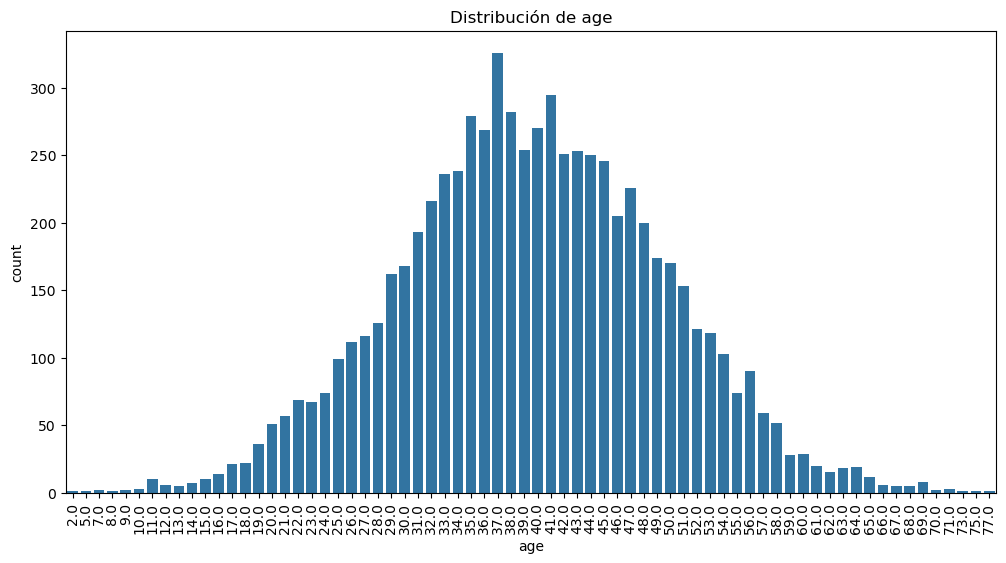

In [1270]:
plt.figure(figsize=(12, 6))
sns.countplot(x="age", data=df)
plt.title('Distribución de age')
plt.xticks(rotation=90)
plt.show()

Esta grafica representa la cantidad de datos que tenemos de distintos rangos de edad, siendo el rango de edad entre 30 y 50 donde mas abundan los datos.
A continuacion vamos a separar los datos, asimilaremos que mas de un 50% de probabilidades como bald para representar los bald y no bald de cada edad

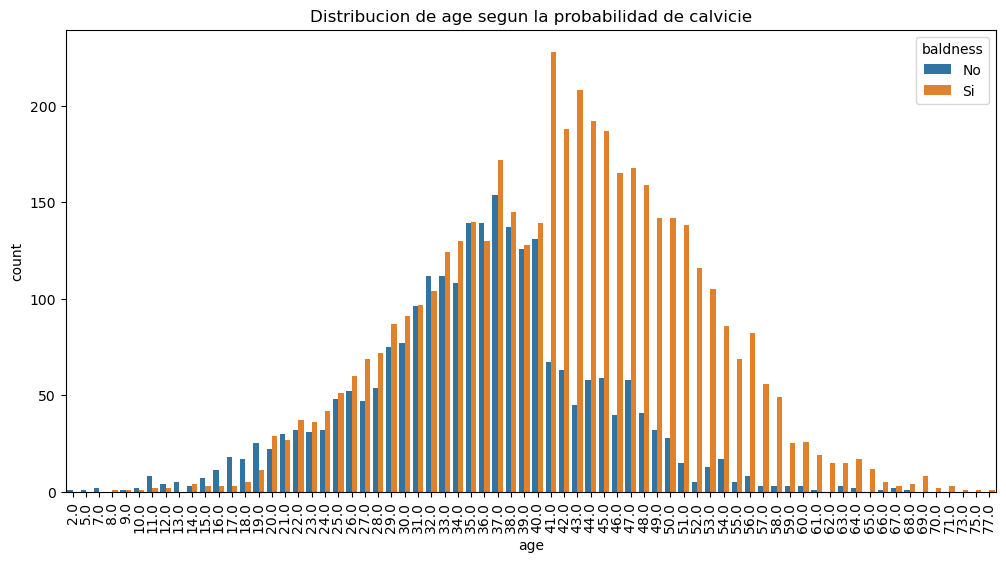

In [1271]:
df['baldness'] = df['bald_prob'].apply(lambda x: 'Si' if x > .50 else 'No')

plt.figure(figsize=(12, 6))
sns.countplot(x="age", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de age segun la probabilidad de calvicie')
plt.xticks(rotation=90)
plt.show()

In [1272]:
df_mayor_40 = df["baldness"][df["age"] > 40]
calvos = df_mayor_40[df_mayor_40 == "Si"].count()
no_calvos = df_mayor_40[df_mayor_40 == "No"].count()
print (f"Proporcion de calvos mayores de 40 años: {calvos / (calvos + no_calvos) * 100:.2f}%")

Proporcion de calvos mayores de 40 años: 82.07%


Esta representacion con un umbral del 50% muestra una mayor cantidad de no bald en edades tempranas (<20 anios), una cantidad pareja de balds y no balds entre los 20 y los 40 anios, y una cantidad de balds en edades mas tardias, un 80% esta bald.

Con esto asumimos que la edad es una variable que tiene algo de correlacion con nuestra variable objetivo: bald_prob

### Correlacion

In [1273]:
df['age'].corr(df['bald_prob'])

0.3627482002454027

No es una correlacion muy grande pero sigue siendo positiva

## Gender

La columna "gender" nos muestra el genero de la persona, male para masculino y female para femenino

#### Describe

In [1274]:
df["gender"].describe()

count     7018
unique       2
top       male
freq      4802
Name: gender, dtype: object

#### Analisis grafico

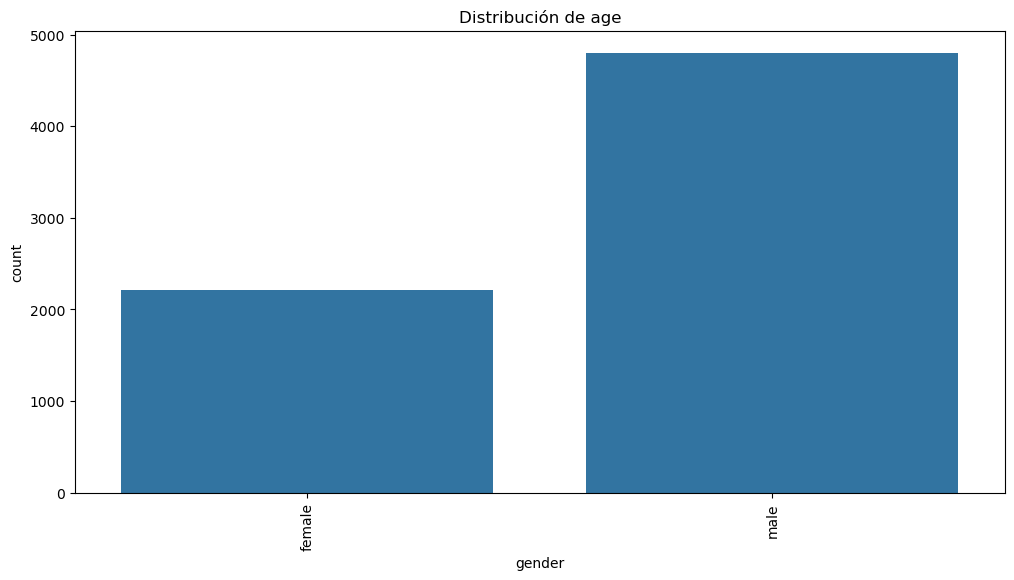

In [1275]:
plt.figure(figsize=(12, 6))
sns.countplot(x="gender", data=df)
plt.title('Distribución de age')
plt.xticks(rotation=90)
plt.show()

Vemos que tenemos mas del doble de valores de hombres que de mujeres

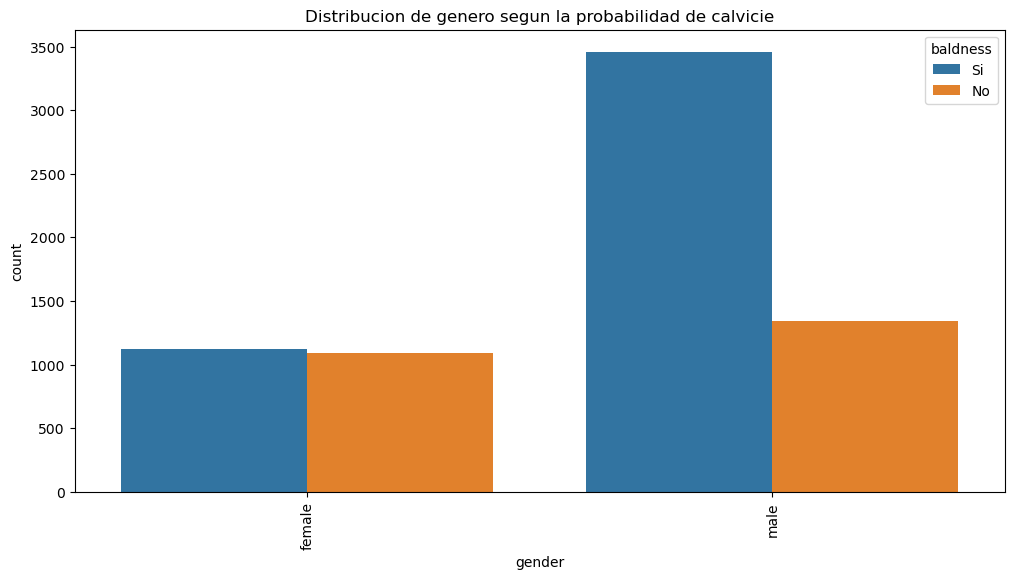

In [1276]:
plt.figure(figsize=(12, 6))
sns.countplot(x="gender", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de genero segun la probabilidad de calvicie')
plt.xticks(rotation=90)
plt.show()

In [1277]:
media_prob_por_genero = df.groupby(df["gender"])["bald_prob"].mean()
print(media_prob_por_genero)

gender
female    0.508858
male      0.603968
Name: bald_prob, dtype: float64


Tanto en la grafica como en la media, vemos que la probabilidad de bald es superior al 50% en ambos generos.  
Veamos que relacion tiene cada genero con bald en base a la edad.

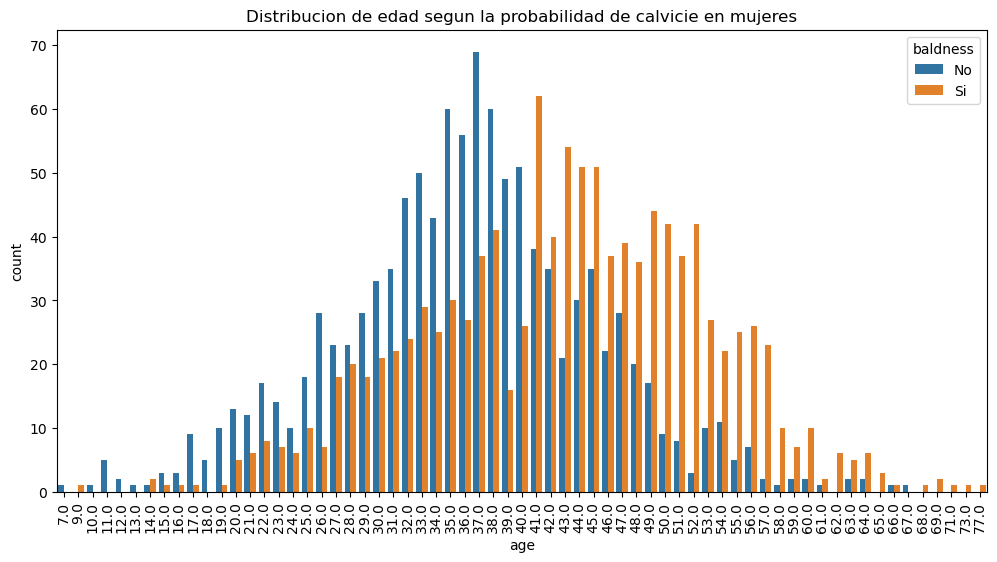

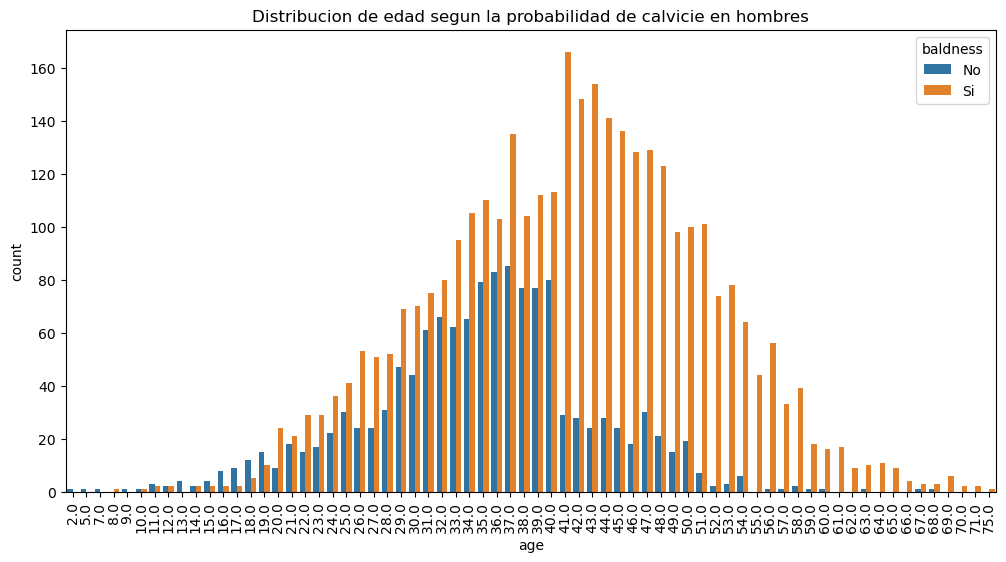

In [1278]:
df_mujeres = df[df["gender"] == "female"]
df_hombres = df[df["gender"] == "male"]

plt.figure(figsize=(12, 6))
sns.countplot(x="age", hue="baldness", data=df_mujeres)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de edad segun la probabilidad de calvicie en mujeres')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="age", hue="baldness", data=df_hombres)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de edad segun la probabilidad de calvicie en hombres')
plt.xticks(rotation=90)
plt.show()

- Hombres:  
A partir de los 20 anios hay mas hombres con mas de un 50% de ser bald que <50%

- Mujeres:  
En las mujeres ese hecho no pasa hasta que se superan los 40 anios

### Correlacion

One Hot Encoding a gender

In [1279]:
df = pd.get_dummies(df, columns=['gender'], dtype=int)
df.head(5)


,age,job_role,province,salary,is_married,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob,baldness,gender_female,gender_male
0,27.0,Government Employee,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,Bachelor Degree,5.0,0.605974,Si,1,0
1,53.0,Government Employee,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,Bachelor Degree,7.0,0.532860,Si,1,0
2,37.0,Employee,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,Bachelor Degree,4.0,0.418442,No,1,0
3,36.0,Jobless,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,Elementary School,9.0,0.804050,Si,1,0
4,38.0,Employee,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,Magister Degree,1.0,0.368371,No,0,1


In [1280]:
df[['gender_female', 'gender_male', 'bald_prob']].corr()

,gender_female,gender_male,bald_prob
gender_female,1.000000,-1.000000,-0.255413
gender_male,-1.000000,1.000000,0.255413
bald_prob,-0.255413,0.255413,1.000000


Se muestra una leve correlacion a la calvicie por ser hombre y las mujeres muestran una menor probabilidad de calvicie

## Job role

La columna "job_role" muestra 3 opciones posibles, trabajador del estado, empleado corriente o desempleado

### Describe

In [1281]:
df["job_role"].describe()

count         7018
unique           3
top       Employee
freq          3375
Name: job_role, dtype: object

### Analisis grafico

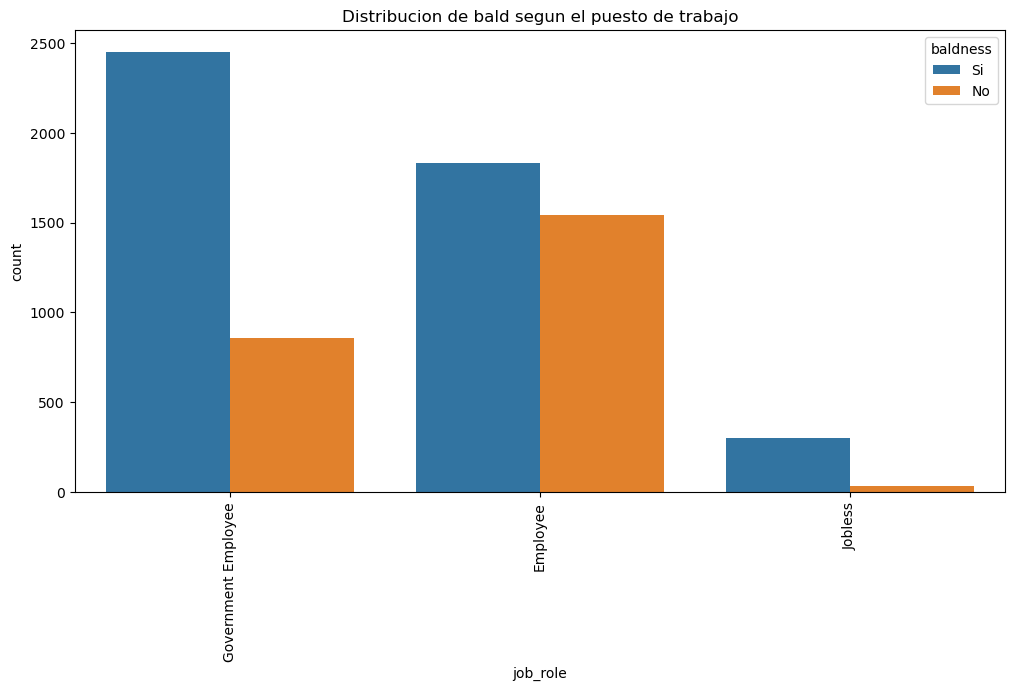

In [1282]:
plt.figure(figsize=(12, 6))
sns.countplot(x="job_role", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun el puesto de trabajo')
plt.xticks(rotation=90)
plt.show()

#### Porcentajes

In [1283]:
jobs = mostrar_jobs()
baldPercentageGov = df["baldness"][df["job_role"] == "Government Employee"].value_counts(normalize=True)["Si"]
baldPercentageEmp = df["baldness"][df["job_role"] == "Employee"].value_counts(normalize=True)["Si"]
baldPercentageJobless = df["baldness"][df["job_role"] == "Jobless"].value_counts(normalize=True)["Si"]
print("\nPorcentaje de personas con mas de un 50% de probabilidades de ser calvo en:")
print(f"\tGoverment Employee: {baldPercentageGov * 100:.2f}%")
print(f"\tEmployee: {baldPercentageEmp * 100:.2f}%")
print(f"\tJobless: {baldPercentageJobless * 100:.2f}%")

Government Employee: 3308/7018 (0.47%)
Employee: 3375/7018 (0.48%)
Jobless: 335/7018 (0.05%)

Porcentaje de personas con mas de un 50% de probabilidades de ser calvo en:
	Goverment Employee: 74.06%
	Employee: 54.28%
	Jobless: 89.85%


### Correlacion

In [1284]:
df = pd.get_dummies(df, columns=['job_role'], dtype=int)
df.head(5)

,age,province,salary,is_married,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob,baldness,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless
0,27.0,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,Bachelor Degree,5.0,0.605974,Si,1,0,0,1,0
1,53.0,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,Bachelor Degree,7.0,0.532860,Si,1,0,0,1,0
2,37.0,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,Bachelor Degree,4.0,0.418442,No,1,0,1,0,0
3,36.0,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,Elementary School,9.0,0.804050,Si,1,0,0,0,1
4,38.0,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,Magister Degree,1.0,0.368371,No,0,1,1,0,0


In [1285]:
df[['job_role_Government Employee', 'job_role_Employee', 'job_role_Jobless', 'bald_prob']].corr()

,job_role_Government Employee,job_role_Employee,job_role_Jobless,bald_prob
job_role_Government Employee,1.000000,-0.908873,-0.211413,0.162972
job_role_Employee,-0.908873,1.000000,-0.215498,-0.289183
job_role_Jobless,-0.211413,-0.215498,1.000000,0.296119
bald_prob,0.162972,-0.289183,0.296119,1.000000


La probabilidad de calvicie parece ser ligeramente mayor entre los desempleados y ligeramente menor entre los empleados. Sin embargo, la relacion no es tan fuerte.

## Is Married

La columna "is_married" nos muestra si la persona esta casada (1) o no (0)

### Describe

In [1286]:
df["is_married"].describe()

count    7018.000000
mean        0.979909
std         0.140322
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_married, dtype: float64

### Analisis grafico

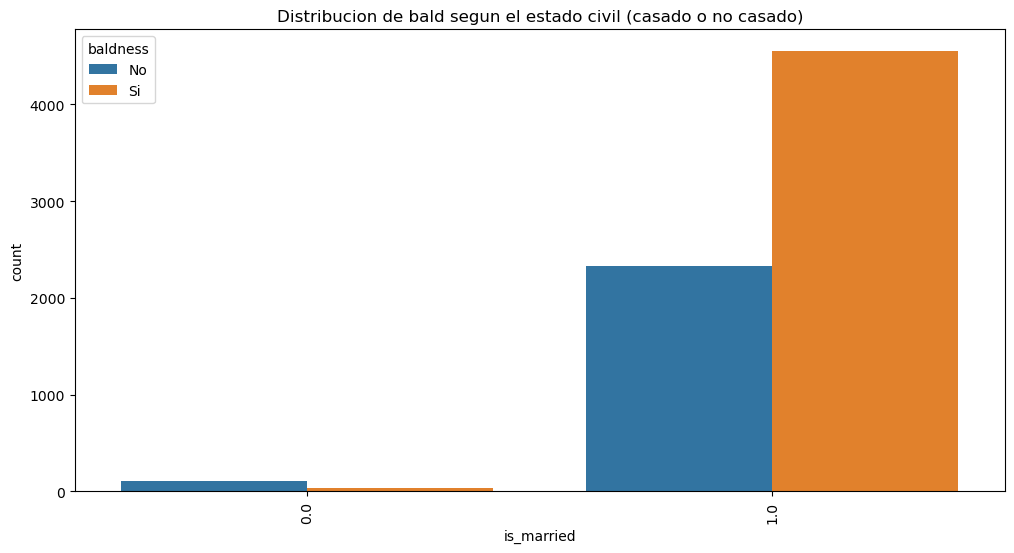

In [1287]:
plt.figure(figsize=(12, 6))
sns.countplot(x="is_married", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun el estado civil (casado o no casado)')
plt.xticks(rotation=90)
plt.show()

In [1288]:
married = df["is_married"][df["is_married"] == 1].count()
notMarried = df["is_married"][df["is_married"] == 0].count()
total = married + notMarried
notMarriedBald = df["baldness"][df["is_married"] == 0].value_counts(normalize=True)["Si"]
marriedBald = df["baldness"][df["is_married"] == 1].value_counts(normalize=True)["Si"]

print(f"Casados: {married}/{total} ({married/total*100:0.2f}%)\nNo casados: {notMarried}/{total} ({notMarried/total*100:0.2f}%)")
print(f"\nPorcentaje de calvos en casados: {marriedBald*100:.2f}%")
print(f"Porcentaje de calvos en no casados: {notMarriedBald*100:.2f}%")

Casados: 6877/7018 (97.99%)
No casados: 141/7018 (2.01%)

Porcentaje de calvos en casados: 66.12%
Porcentaje de calvos en no casados: 25.53%


Aunque no hay suficientes datos como para darlo por hecho, las personas no casadas muestran una menor probabilidad de quedarse calvos.

## Province

Muestra la capital de Indonesia de la persona que se hizo el analisis.

In [1289]:
df["province"].unique()

array(['Bengkulu', 'Bandung', 'Palu', 'Palangkaraya', 'Serang',
       'Banda Aceh', 'Palembang', 'Kupang', 'Sofifi', 'Ambon',
       'Tanjungselor', 'Tanjung Pinang', 'Banjarmasin', 'Denpasar',
       'Mamuju', 'Pangkalpinang', 'Yogyakarta', 'Makassar', 'Pontianak',
       'Mataram', 'Manokwari', 'Gorontalo', 'Semarang', 'Surabaya',
       'Jakarta', 'Banda Lampung', 'Jayapura', 'Pekanbaru', 'Jambi',
       'Manado', 'Medan', 'Kendari', 'Samarinda', 'Padang'], dtype=object)

## Representacion grafica

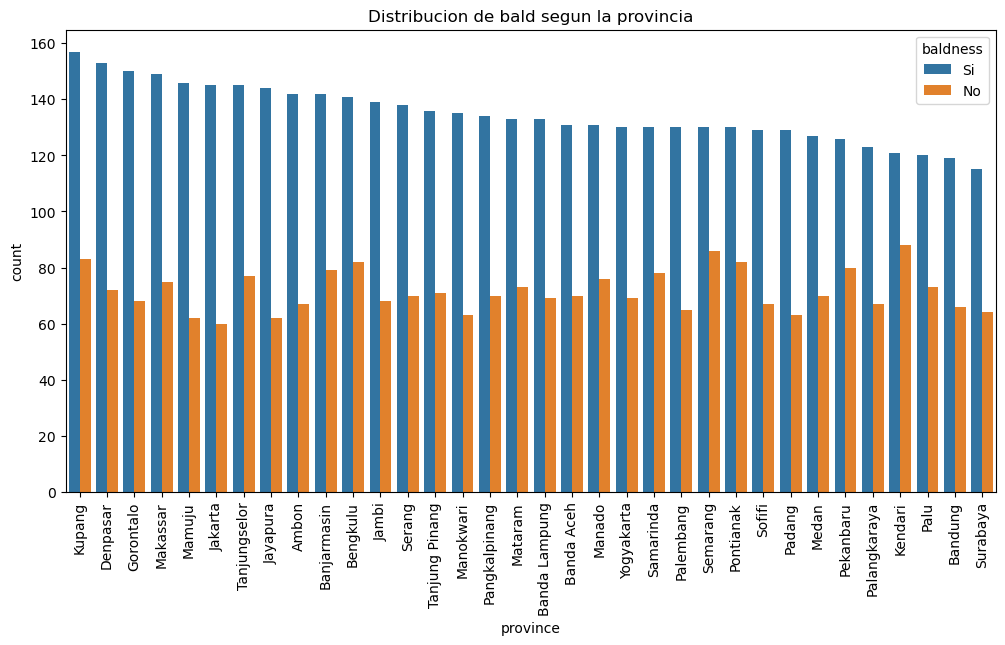

In [1290]:
ordenadoPorBaldPositivo = df["province"][df["baldness"] == "Si"].value_counts().index

plt.figure(figsize=(12, 6))
sns.countplot(x="province", hue="baldness", data=df, order=ordenadoPorBaldPositivo)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la provincia')
plt.xticks(rotation=90)
plt.show()

En esta representacion descendente de personas con mas de un 50% de probabilidades de quedarse calvo, los datos no estan pronunciadamente sesgados.

### Vamos a mostrar la media de probabilidad de calvicie por provincia

In [1291]:
mediasPorProvincia = df.groupby(df["province"])["bald_prob"].mean()
mediasPorProvincia.describe()

count    34.000000
mean      0.573955
std       0.010876
min       0.538143
25%       0.569712
50%       0.574933
75%       0.578098
max       0.595227
Name: bald_prob, dtype: float64

Como vemos, la media de cada provincia esta entre el 53% y el 59%

### One hot encoding

Como no hay provicias que sean mas propensas a tener mas probabilidad de calvos que otras, vamos a aplicar one hot encoding para no dar mas importancia a unas provincias que otras.

In [1292]:
df = pd.get_dummies(df, columns=['province'], dtype=int)
df.head(5)

,age,salary,is_married,is_hereditary,weight,height,shampoo,is_smoker,education,stress,bald_prob,baldness,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta
0,27.0,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,Bachelor Degree,5.0,0.605974,Si,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53.0,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,Bachelor Degree,7.0,0.532860,Si,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37.0,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,Bachelor Degree,4.0,0.418442,No,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36.0,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,Elementary School,9.0,0.804050,Si,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,38.0,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,Magister Degree,1.0,0.368371,No,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Salary

### Describe

In [1293]:
df["salary"].describe()

count    7.018000e+03
mean     8.829976e+06
std      4.483586e+06
min      1.500000e+06
25%      5.711825e+06
50%      7.812835e+06
75%      1.082371e+07
max      5.000000e+07
Name: salary, dtype: float64

### Analisis grafico

In [1294]:
df['salary'].unique

<bound method Series.unique of 0       7.957453e+06
1       7.633003e+06
2       6.637625e+06
3       3.624871e+06
4       6.031808e+06
            ...     
7911    5.326614e+06
7912    6.024409e+06
7913    1.007043e+07
7914    8.010815e+06
7916    1.769162e+07
Name: salary, Length: 7018, dtype: float64>

Primero vamos a separar los sueldos en grupos, debido a la gran cantidad de datos distintos que hay, mi objetivo sera separar los suelos en grupos, estos grupos seran el salarioMax / salarioActual

In [1295]:
salarioMax = df["salary"].max()
salarioMin = df["salary"].min()

cantidadDeGrupos = salarioMax / salarioMin
print(cantidadDeGrupos)

33.333333333333336


Con esto sabemos que el grupo mas grande de los salarios ha de ser 33

In [1296]:
df["salary"] = (salarioMax / df["salary"]).astype(int)
df["salary"].describe()

count    7018.000000
mean        6.530493
std         3.347312
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        33.000000
Name: salary, dtype: float64

Ha salido bien, hemos reducido los datos de los sueldos sin perder su esencia

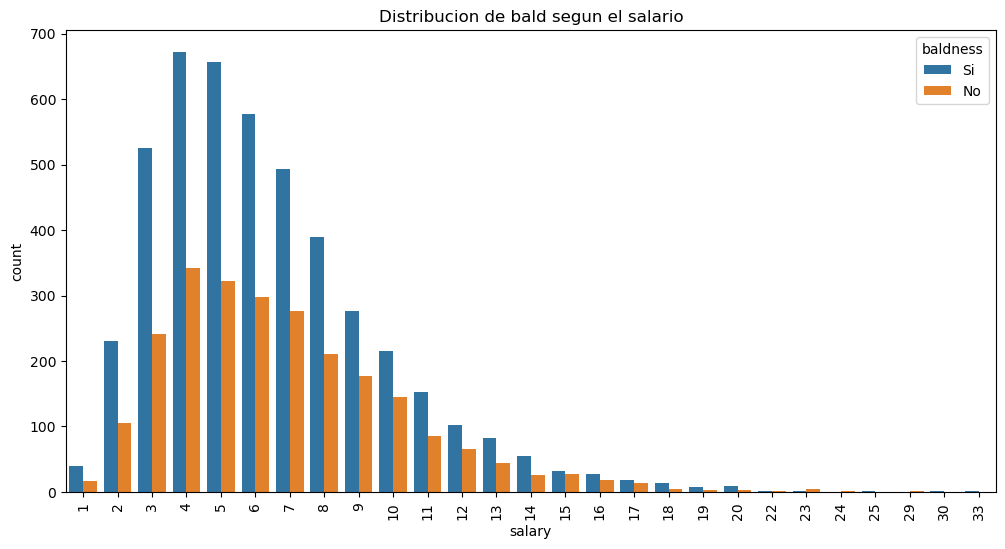

In [1297]:
plt.figure(figsize=(12, 6))
sns.countplot(x="salary", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun el salario')
plt.xticks(rotation=90)
plt.show()

In [1298]:
grupos = df["salary"].unique()
grupos = np.sort(grupos)

Vamos a comprobar los porcentajes de personas con mas de un 50% de posibilidades de ser bald de todos los grupos salariales para asi ver si realmente la caracteristica salario tiene importancia.

In [1299]:
for i in grupos:
    bald_counts = df["baldness"][df["salary"] == i].value_counts(normalize=True)
    baldPercentageSalary = bald_counts.get("Si", 0)
    print(f"Porcentaje de calvos en el grupo de salario {i}: {baldPercentageSalary * 100:.2f}%")

Porcentaje de calvos en el grupo de salario 1: 71.43%
Porcentaje de calvos en el grupo de salario 2: 68.55%
Porcentaje de calvos en el grupo de salario 3: 68.54%
Porcentaje de calvos en el grupo de salario 4: 66.27%
Porcentaje de calvos en el grupo de salario 5: 67.11%
Porcentaje de calvos en el grupo de salario 6: 65.94%
Porcentaje de calvos en el grupo de salario 7: 64.07%
Porcentaje de calvos en el grupo de salario 8: 64.94%
Porcentaje de calvos en el grupo de salario 9: 61.01%
Porcentaje de calvos en el grupo de salario 10: 59.72%
Porcentaje de calvos en el grupo de salario 11: 63.87%
Porcentaje de calvos en el grupo de salario 12: 61.31%
Porcentaje de calvos en el grupo de salario 13: 64.84%
Porcentaje de calvos en el grupo de salario 14: 67.90%
Porcentaje de calvos en el grupo de salario 15: 54.24%
Porcentaje de calvos en el grupo de salario 16: 60.00%
Porcentaje de calvos en el grupo de salario 17: 58.06%
Porcentaje de calvos en el grupo de salario 18: 73.68%
Porcentaje de calvo

### Correlacion

In [1300]:
df[['salary', 'bald_prob']].corr()

,salary,bald_prob
salary,1.000000,-0.044811
bald_prob,-0.044811,1.000000


Esta columna no tiene ningun tipo de correlacion, siendo esta muy cercana al 0, (-0.04), vamos a prescindir de ella

In [1301]:
df = df.drop(columns=['salary'])

## Is hereditary

### Describe

In [1302]:
df["is_hereditary"].describe()

count    7018.000000
mean        0.204902
std         0.403659
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_hereditary, dtype: float64

### Representacion grafica

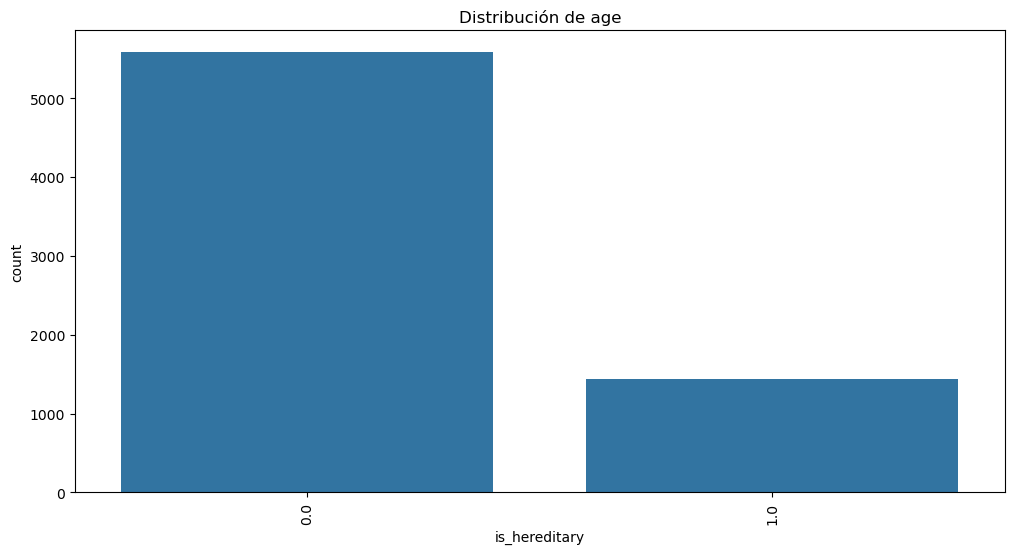

In [1303]:
plt.figure(figsize=(12, 6))
sns.countplot(x="is_hereditary", data=df)
plt.title('Distribución de age')
plt.xticks(rotation=90)
plt.show()

Vemos que de los datos que tenemos, la gran mayoria son no hereditario

Vamos a ver la cantidad de personas con mas de un 50% de bald en personas con bald hereditario y no hereditario

In [1304]:
noHeredirario = df["is_hereditary"][df["is_hereditary"] == 0].count()
heredirario = df["is_hereditary"][df["is_hereditary"] == 1].count()

print(f"No hereditario: {noHeredirario}/{noHeredirario + heredirario} ({noHeredirario/(noHeredirario + heredirario)*100:.2f}%)")
print(f"Heredirario: {heredirario}/{noHeredirario + heredirario} ({heredirario/(noHeredirario + heredirario)*100:.2f}%)")

No hereditario: 5580/7018 (79.51%)
Heredirario: 1438/7018 (20.49%)


In [1305]:
noHeredirarioBald = df["baldness"][df["is_hereditary"] == 0].value_counts(normalize=True)["Si"]
heredirarioBald = df["baldness"][df["is_hereditary"] == 1].value_counts(normalize=True)["Si"]
print(f"\nPorcentaje de calvos en no hereditarios: {noHeredirarioBald*100:.2f}%")
print(f"Porcentaje de calvos en hereditarios: {heredirarioBald*100:.2f}%")


Porcentaje de calvos en no hereditarios: 58.10%
Porcentaje de calvos en hereditarios: 93.25%


Como vemos, la herencia de bald desarrolla un gran papel en las probabilidades de bald, las personas directamente herederas son muy propensas a tener bald, ya que el 93.25% de ellas tienen mas de un 50% de bald, y en personas no hereditarias, siguen siendo el 58% de las personas las que tienen mas de un 50% de probabilidades de ser bald

## Weight

### Describe

In [1306]:
df['weight'].describe()

count    7018.000000
mean       55.904161
std         9.538500
min        40.319619
25%        49.281156
50%        53.808418
75%        60.220508
max       126.042823
Name: weight, dtype: float64

### Analisis grafico

In [1307]:
df['weight'] = df['weight'].astype(int)
df['weight'].unique

<bound method Series.unique of 0       54
1       72
2       46
3       51
4       60
        ..
7911    50
7912    44
7913    49
7914    54
7916    81
Name: weight, Length: 7018, dtype: int32>

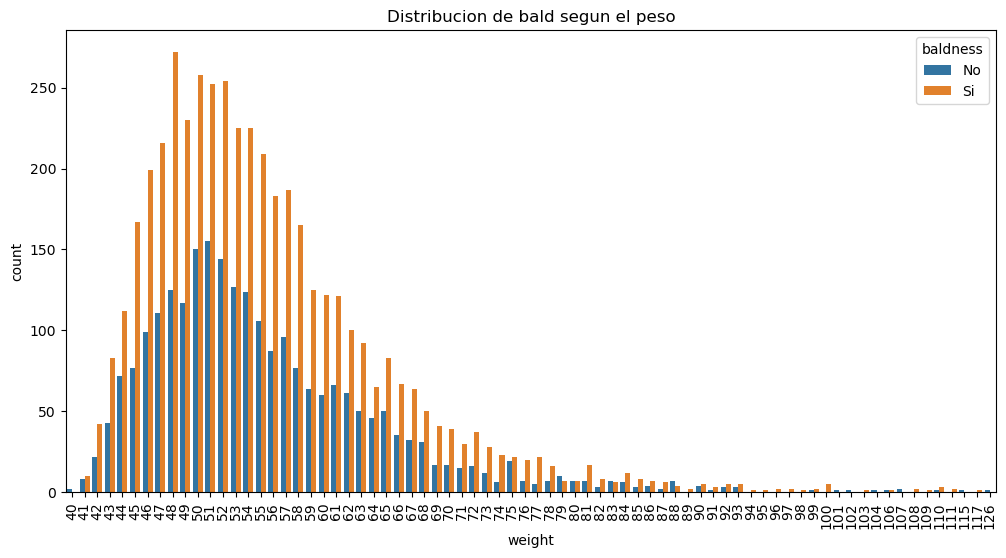

In [1308]:
plt.figure(figsize=(12, 6))
sns.countplot(x="weight", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun el peso')
plt.xticks(rotation=90)
plt.show()

### Vamos a comprobar la correlacion

In [1309]:
df[['weight', 'bald_prob']].corr()

,weight,bald_prob
weight,1.000000,-0.003643
bald_prob,-0.003643,1.000000


Como vemos, esta columna tambien tiene una correlacion bajisima con nuestra variable objetivo asi que vamos a eliminarla tambien

In [1310]:
df = df.drop(columns=['weight'])

## Height

Height muestra la altura de las personas en cm

Describe

In [1311]:
df["height"].describe()

count    7018.000000
mean      167.255084
std        10.922452
min       127.993496
25%       159.734349
50%       167.155658
75%       174.437997
max       211.285582
Name: height, dtype: float64

### Analisis grafico

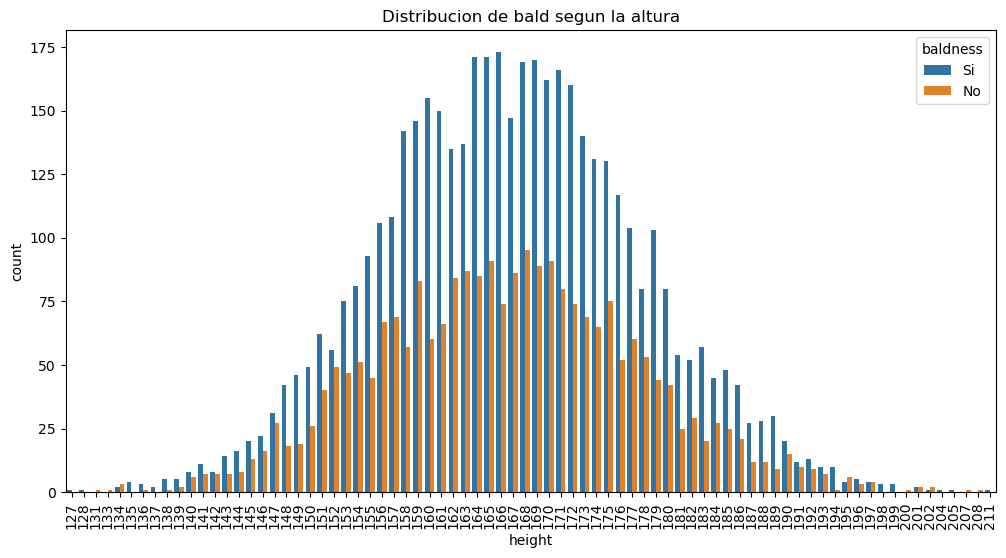

In [1312]:
df['height'] = df['height'].astype(int)

plt.figure(figsize=(12, 6))
sns.countplot(x="height", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la altura')
plt.xticks(rotation=90)
plt.show()

Vemos datos parecidos a los de weight solo que estos datos no estan segados y tienen forma de campana

### Correlacion

In [1313]:
df["height"].corr(df["bald_prob"])

0.009780248547207262

Vemos que height tiene una correlacion bajisima, vamos a eliminarla

In [1314]:
df = df.drop(columns=['height'])

## Shampoo

### Describe

In [1315]:
print(df["shampoo"].describe())
df["shampoo"].unique()

count         7018
unique           5
top       Deadbuoy
freq          1450
Name: shampoo, dtype: object


array(['Pantone', 'Moonsilk', 'Deadbuoy', 'Merpati', 'Shoulder & Head'],
      dtype=object)

### Analisis grafico

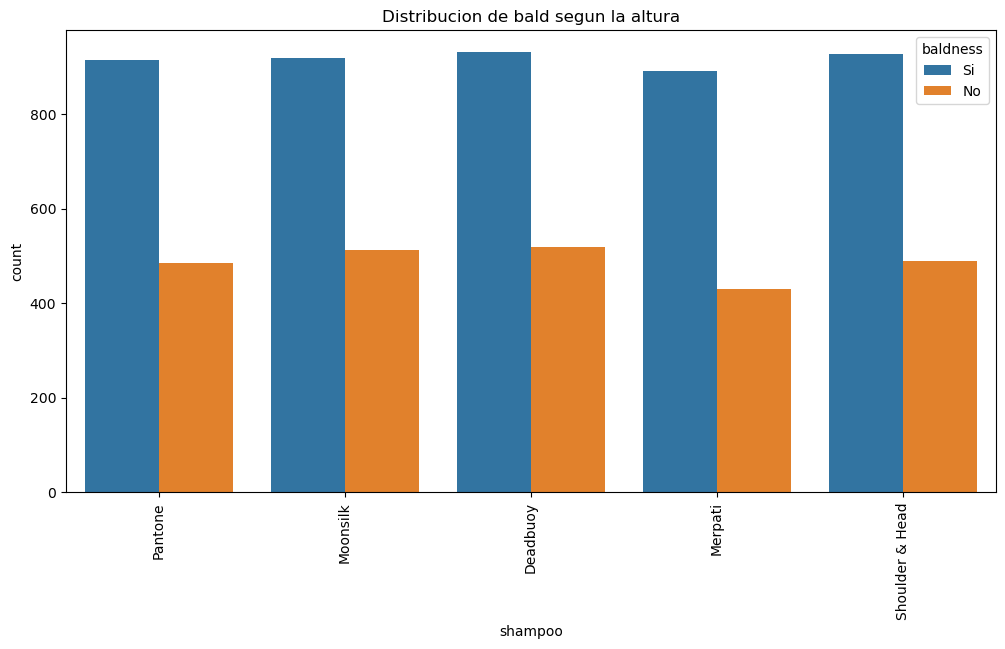

In [1316]:
plt.figure(figsize=(12, 6))
sns.countplot(x="shampoo", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la altura')
plt.xticks(rotation=90)
plt.show()

Vemos un reparto equitativo en los shampoo del estudio, donde los valores casi no varian

## Is smoker

Muestra si la persona fuma

### Describe

In [1317]:
df["is_smoker"].describe()

count    7018.000000
mean        0.494443
std         0.500005
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_smoker, dtype: float64

Vemos que los datos estan representados en 0, no fuma, o 1, si fuma

### Analisis grafico

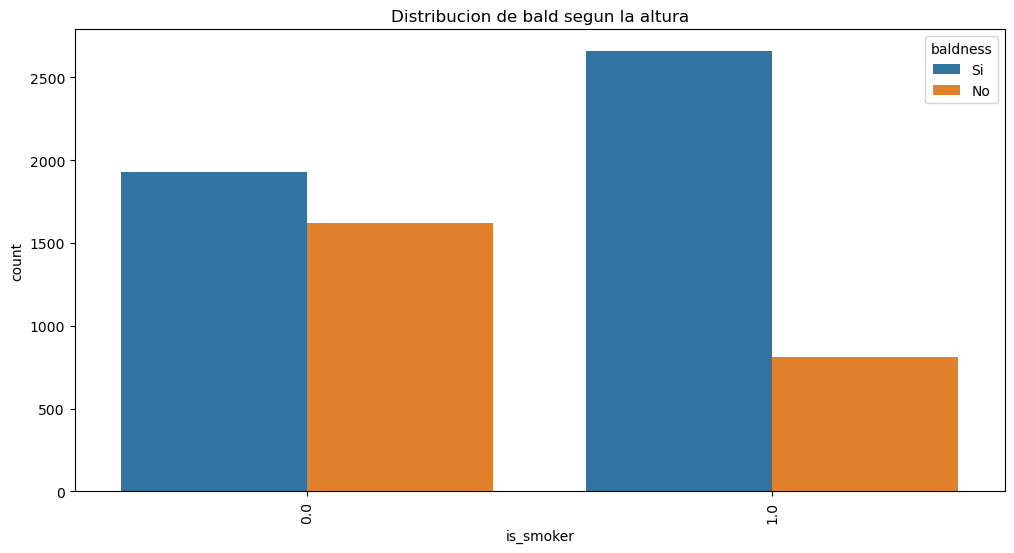

In [1318]:
plt.figure(figsize=(12, 6))
sns.countplot(x="is_smoker", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la altura')
plt.xticks(rotation=90)
plt.show()

Vemos una clara relacion donde las personas que fuman tienen en su mayoria mas de un 50% de probabilidades de quedarse calvo

## Education

En education vemos los estudios de la persona

In [1319]:
print(df["education"].describe())
df["education"].unique()

count                7018
unique                  6
top       Bachelor Degree
freq                 3874
Name: education, dtype: object


array(['Bachelor Degree', 'Elementary School', 'Magister Degree',
       'Senior High School', 'Junior High School', 'Doctoral Degree'],
      dtype=object)

### Analisis grafico

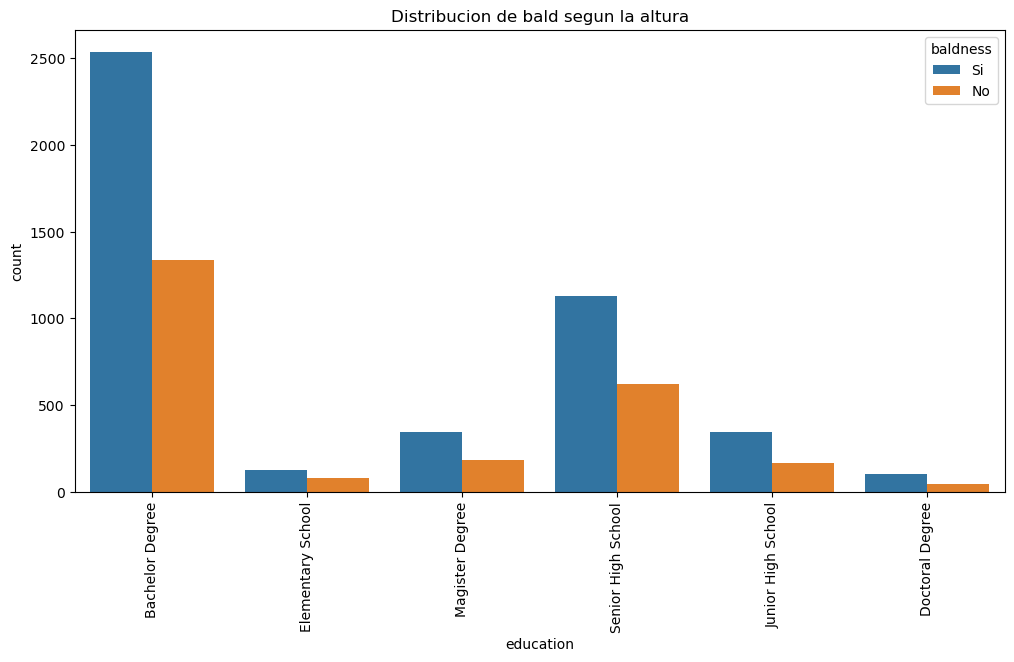

In [1320]:
plt.figure(figsize=(12, 6))
sns.countplot(x="education", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la altura')
plt.xticks(rotation=90)
plt.show()

In [1321]:
educationDicc = {
    "Bachelor Degree" : df["baldness"][df["education"] == "Bachelor Degree"].value_counts(normalize=True)["Si"],
    "Elementary School" : df["baldness"][df["education"] == "Elementary School"].value_counts(normalize=True)["Si"],
    "Magister Degree" : df["baldness"][df["education"] == "Magister Degree"].value_counts(normalize=True)["Si"],
    "Senior High School" : df["baldness"][df["education"] == "Senior High School"].value_counts(normalize=True)["Si"],
    "Junior High School" : df["baldness"][df["education"] == "Junior High School"].value_counts(normalize=True)["Si"],
    "Doctoral Degree" : df["baldness"][df["education"] == "Doctoral Degree"].value_counts(normalize=True)["Si"]
}
print("\nPorcentaje de personas con mas de un 50% de probabilidades de ser calvo en:")
for key, value in educationDicc.items():
    print(f"\t{key}: {value*100:.2f}%")


Porcentaje de personas con mas de un 50% de probabilidades de ser calvo en:
	Bachelor Degree: 65.46%
	Elementary School: 61.27%
	Magister Degree: 64.98%
	Senior High School: 64.55%
	Junior High School: 67.52%
	Doctoral Degree: 69.18%


El porcentaje de personas con mas de un 50% es similar en todos los estudios

### Correlacion

In [1322]:
df = pd.get_dummies(df, columns=['education'], dtype=int)
df.head(2)

,age,is_married,is_hereditary,shampoo,is_smoker,stress,bald_prob,baldness,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta,education_Bachelor Degree,education_Doctoral Degree,education_Elementary School,education_Junior High School,education_Magister Degree,education_Senior High School
0,27.0,1.0,0.0,Pantone,1.0,5.0,0.605974,Si,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,53.0,1.0,0.0,Pantone,0.0,7.0,0.532860,Si,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [1323]:
df[['education_Bachelor Degree', 'education_Elementary School', 'education_Magister Degree', 'education_Senior High School', 'education_Junior High School', 'education_Doctoral Degree', 'bald_prob']].corr()

,education_Bachelor Degree,education_Elementary School,education_Magister Degree,education_Senior High School,education_Junior High School,education_Doctoral Degree,bald_prob
education_Bachelor Degree,1.000000,-0.192067,-0.318557,-0.640273,-0.310084,-0.161798,0.002638
education_Elementary School,-0.192067,1.000000,-0.049655,-0.099802,-0.048334,-0.025220,-0.016519
education_Magister Degree,-0.318557,-0.049655,1.000000,-0.165530,-0.080166,-0.041830,0.003401
education_Senior High School,-0.640273,-0.099802,-0.165530,1.000000,-0.161127,-0.084074,-0.005128
education_Junior High School,-0.310084,-0.048334,-0.080166,-0.161127,1.000000,-0.040717,0.001105
education_Doctoral Degree,-0.161798,-0.025220,-0.041830,-0.084074,-0.040717,1.000000,0.017478
bald_prob,0.002638,-0.016519,0.003401,-0.005128,0.001105,0.017478,1.000000


Correlacion bajisima

In [1324]:
df = df.drop(columns=['education_Bachelor Degree', 'education_Elementary School', 'education_Magister Degree', 'education_Senior High School', 'education_Junior High School', 'education_Doctoral Degree'])

## Stress

### Describe

In [1325]:
df["stress"].describe()

count    7018.000000
mean        5.450271
std         2.860570
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: stress, dtype: float64

### Analisis grafico

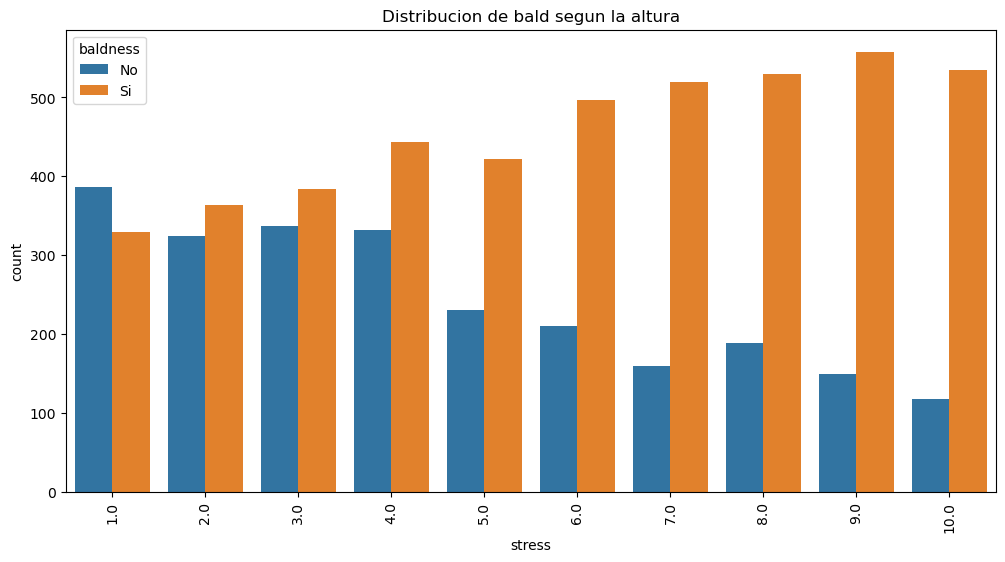

In [1326]:
plt.figure(figsize=(12, 6))
sns.countplot(x="stress", hue="baldness", data=df)

for p in plt.gca().patches:
    height = p.get_height()
    p.set_height(height)
plt.title('Distribucion de bald segun la altura')
plt.xticks(rotation=90)
plt.show()

Esta variable es muy importante, se ve claramente que mientras mas estres, mas probabilidad de ser calvo hay

## Tecnicas de encoding necesarias/oportunas

In [1327]:
df.head(2)

,age,is_married,is_hereditary,shampoo,is_smoker,stress,bald_prob,baldness,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta
0,27.0,1.0,0.0,Pantone,1.0,5.0,0.605974,Si,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53.0,1.0,0.0,Pantone,0.0,7.0,0.532860,Si,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1328]:
df = pd.get_dummies(df, columns=['shampoo'], dtype=int)

In [1329]:
df.describe()

,age,is_married,is_hereditary,is_smoker,stress,bald_prob,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta,shampoo_Deadbuoy,shampoo_Merpati,shampoo_Moonsilk,shampoo_Pantone,shampoo_Shoulder & Head
count,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000,7018.000000
mean,39.514819,0.979909,0.204902,0.494443,5.450271,0.573936,0.315759,0.684241,0.480906,0.471359,0.047734,0.029781,0.028641,0.028783,0.026361,0.031490,0.031775,0.032060,0.031063,0.029211,0.029496,0.029353,0.029781,0.034198,0.031918,0.029638,0.029496,0.028213,0.029353,0.028071,0.027358,0.027073,0.027786,0.027501,0.029068,0.029353,0.030208,0.029638,0.030778,0.029638,0.027928,0.025506,0.029496,0.031633,0.028356,0.206612,0.188230,0.204047,0.199487,0.201624
std,9.885182,0.140322,0.403659,0.500005,2.860570,0.173100,0.464851,0.464851,0.499671,0.499215,0.213219,0.169994,0.166806,0.167208,0.160217,0.174652,0.175414,0.176173,0.173500,0.168408,0.169203,0.168806,0.169994,0.181750,0.175794,0.169599,0.169203,0.165593,0.168806,0.165187,0.163137,0.162308,0.164370,0.163549,0.168009,0.168806,0.171172,0.169599,0.172728,0.169599,0.164779,0.157667,0.169203,0.175033,0.165999,0.404903,0.390924,0.403032,0.399643,0.401242
min,2.000000,0.000000,0.000000,0.000000,1.000000,0.064633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,0.000000,3.000000,0.453578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,0.000000,0.000000,5.000000,0.567860,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.000000,1.000000,0.000000,1.000000,8.000000,0.686587,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

Age es la unica columna a la que no le hemos hecho nada, vamos a aplicarle min max scaler

In [1330]:
min_max_scaler = MinMaxScaler()
df["age"] = min_max_scaler.fit_transform(df[["age"]])

# Pruebas con modelo de regresion lineal

## Con datos sin escalar

Para ello vamos a volver a importar el df en una variable con otro nombre y vamos a aplicarle los preprocesados necesarios, como la conversion de categorias a numericos

In [1331]:
df2 = pd.read_csv("./bald_probability.csv")

proporciones = {
    'Government Employee': 0.47,
    'Employee': 0.48,
    'Jobless': 0.05
}

n_nan = df2['job_role'].isna().sum()
categorias = list(proporciones.keys())
probabilidades = list(proporciones.values())
nan_indices = df2['job_role'].isna()
df2.loc[nan_indices, 'job_role'] = np.random.choice(categorias, size=n_nan, p=probabilidades)

df2.dropna(inplace=True)

df2 = pd.get_dummies(df2, columns=['gender'], dtype=int)
df2 = pd.get_dummies(df2, columns=['job_role'], dtype=int)
df2 = pd.get_dummies(df2, columns=['province'], dtype=int)
df2 = pd.get_dummies(df2, columns=['education'], dtype=int)
df2 = pd.get_dummies(df2, columns=['shampoo'], dtype=int)

df2.head(2)

,age,salary,is_married,is_hereditary,weight,height,is_smoker,stress,bald_prob,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta,education_Bachelor Degree,education_Doctoral Degree,education_Elementary School,education_Junior High School,education_Magister Degree,education_Senior High School,shampoo_Deadbuoy,shampoo_Merpati,shampoo_Moonsilk,shampoo_Pantone,shampoo_Shoulder & Head
0,27.0,7.957453e+06,1.0,0.0,54.315053,170.428542,1.0,5.0,0.605974,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,53.0,7.633003e+06,1.0,0.0,72.873404,165.530097,0.0,7.0,0.532860,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### Obtener modelo

In [1332]:
X = df2.drop(columns=['bald_prob'])
X_miTest_sinProcesar = X.iloc[-1]
X = X.iloc[:-1]
y = df2['bald_prob']
y_miTest_sinProcesar = y.iloc[-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modeloSinProcesar = modelo.fit(X_train, y_train)

y_pred = modeloSinProcesar.predict(X_test)

r21 = modeloSinProcesar.score(X_test, y_test)
mse1 = mean_squared_error(y_test, y_pred)

print(f"Precisión del modelo (R²): {r21:.2f}")
print(f"Fallo cuadrático medio (MSE): {mse1:.2f}")
rmse1 = np.sqrt(mse1)

print("RMSE:", rmse1)

Precisión del modelo (R²): 0.68
Fallo cuadrático medio (MSE): 0.01
RMSE: 0.09663109917611344


## Con datos escalados

In [1333]:
df = df.drop(columns=['baldness'])

In [1334]:
X.head(2)

,age,salary,is_married,is_hereditary,weight,height,is_smoker,stress,gender_female,gender_male,job_role_Employee,job_role_Government Employee,job_role_Jobless,province_Ambon,province_Banda Aceh,province_Banda Lampung,province_Bandung,province_Banjarmasin,province_Bengkulu,province_Denpasar,province_Gorontalo,province_Jakarta,province_Jambi,province_Jayapura,province_Kendari,province_Kupang,province_Makassar,province_Mamuju,province_Manado,province_Manokwari,province_Mataram,province_Medan,province_Padang,province_Palangkaraya,province_Palembang,province_Palu,province_Pangkalpinang,province_Pekanbaru,province_Pontianak,province_Samarinda,province_Semarang,province_Serang,province_Sofifi,province_Surabaya,province_Tanjung Pinang,province_Tanjungselor,province_Yogyakarta,education_Bachelor Degree,education_Doctoral Degree,education_Elementary School,education_Junior High School,education_Magister Degree,education_Senior High School,shampoo_Deadbuoy,shampoo_Merpati,shampoo_Moonsilk,shampoo_Pantone,shampoo_Shoulder & Head
0,27.0,7.957453e+06,1.0,0.0,54.315053,170.428542,1.0,5.0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,53.0,7.633003e+06,1.0,0.0,72.873404,165.530097,0.0,7.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [1335]:
X = df.drop(columns=['bald_prob'])
X_miTest_Procesado = X.iloc[-1]
X = X.iloc[:-1]
y = df['bald_prob']
y_miTest_Procesado = y.iloc[-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modeloProcesado = modelo.fit(X_train, y_train)

y_pred = modeloProcesado.predict(X_test)

r22 = modeloProcesado.score(X_test, y_test)
mse2 = mean_squared_error(y_test, y_pred)

print(f"Precisión del modelo (R²): {r22:.2f}")
print(f"Fallo cuadrático medio (MSE): {mse2:.2f}")
rmse2 = np.sqrt(mse2)

print("RMSE:", rmse2)

Precisión del modelo (R²): 0.68
Fallo cuadrático medio (MSE): 0.01
RMSE: 0.09572798214588357


## Escalando la salida de ambos modelos

### Modelo sin escalar

In [1336]:
X = df2.drop(columns=['bald_prob'])
X_miTest_sinProcesar_yEscalado = X.iloc[-1]
X = X.iloc[:-1]
y = df2['bald_prob']

standardScaler = StandardScaler()
y = standardScaler.fit_transform(y.values.reshape(-1, 1))

y_miTest_sinProcesar_yEscalado = y[-1]
y = y[:-1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modeloSinProcesar_yEscalada = modelo.fit(X_train, y_train)

y_pred = modeloSinProcesar_yEscalada.predict(X_test)

r23 = modeloSinProcesar_yEscalada.score(X_test, y_test)
mse3 = mean_squared_error(y_test, y_pred)

print(f"Precisión del modelo (R²): {r23:.2f}")
print(f"Fallo cuadrático medio (MSE): {mse3:.2f}")
rmse3 = np.sqrt(mse3)

print("RMSE:", rmse3)

Precisión del modelo (R²): 0.68
Fallo cuadrático medio (MSE): 0.31
RMSE: 0.5582791658047158


### Modelo escalado

In [1337]:
X = df.drop(columns=['bald_prob'])
X_miTest_Procesado_yEscalado = X.iloc[-1]
X = X.iloc[:-1]
y = df['bald_prob']

y = standardScaler.fit_transform(y.values.reshape(-1, 1))

y_miTest_Procesado_yEscalado = y[-1]
y = y[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modeloProcesado_yEscalada = modelo.fit(X_train, y_train)

y_pred = modeloProcesado_yEscalada.predict(X_test)

r24 = modeloProcesado_yEscalada.score(X_test, y_test)
mse4 = mean_squared_error(y_test, y_pred)

print(f"Precisión del modelo (R²): {r24:.2f}")
print(f"Fallo cuadrático medio (MSE): {mse4:.2f}")
rmse4 = np.sqrt(mse4)

print("RMSE:", rmse4)

Precisión del modelo (R²): 0.68
Fallo cuadrático medio (MSE): 0.31
RMSE: 0.5530729632630665


In [1338]:
print("Predicción sin procesar:")
print(modeloSinProcesar.predict([X_miTest_sinProcesar]))
print("Reultado esperado:", y_miTest_sinProcesar, "\n")

print("Predicción procesada:")
print(modeloProcesado.predict([X_miTest_Procesado]))
print("Reultado esperado:", y_miTest_Procesado, "\n")

print("Predicción sin procesar y escalada:")
print(modeloSinProcesar_yEscalada.predict([X_miTest_sinProcesar_yEscalado]))
print("Reultado esperado:", y_miTest_sinProcesar_yEscalado, "\n")

print("Predicción procesada y escalada:")
print(modeloProcesado_yEscalada.predict([X_miTest_Procesado_yEscalado]))
print("Reultado esperado:", y_miTest_Procesado_yEscalado, "\n")

Predicción sin procesar:
[0.86103645]
Reultado esperado: 0.8721238515964617 

Predicción procesada:
[0.84823608]
Reultado esperado: 0.8721238515964617 

Predicción sin procesar y escalada:
[[1.65869984]]
Reultado esperado: [1.72275651] 

Predicción procesada y escalada:
[[1.58508301]]
Reultado esperado: [1.72275651] 



c:\Users\marco\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\marco\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\marco\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\marco\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [1340]:
data = {
    "Modelo": ["Sin procesar", "Procesado", "Sin procesar y escalado", "Procesado y escalado"],
    "R²": [r21, r22, r23, r24],
    "MSE": [mse1, mse2, mse3, mse4],
    "RMSE": [rmse1, rmse2, rmse3, rmse4]
}

df_resultados = pd.DataFrame(data)
df_resultados

,Modelo,R²,MSE,RMSE
0,Sin procesar,0.676607,0.009338,0.096631
1,Procesado,0.682624,0.009164,0.095728
2,Sin procesar y escalado,0.676607,0.311676,0.558279
3,Procesado y escalado,0.682611,0.305890,0.553073
